In [ ]:
#Instalación de Kaggle
!pip install -q kaggle

In [ ]:
from google.colab import files
#subir kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"erikamarlene","key":"2336a21daaa2f44411802d9434b732b3"}'}

In [ ]:
#Configurar biblioteca de kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json #Colocamos el archivo en la carpeta
!chmod ~/.kaggle/kaggle.json 600 #Permiso 600 (lectura y escritura)

mkdir: cannot create directory ‘/root/.kaggle’: File exists
chmod: invalid mode: ‘/root/.kaggle/kaggle.json’
Try 'chmod --help' for more information.


# Problemática
Decidí usar un dataset con imágenes de 525 diferentes especies de aves. Usando Convolutional Neural Network intentaré clasificar correctamente dichas imágenes de aves.

In [ ]:
# Descargar dataset
!kaggle datasets download -d gpiosenka/100-bird-species

100% 1.96G/1.96G [00:20<00:00, 33.6MB/s]
100% 1.96G/1.96G [00:20<00:00, 105MB/s] 


In [ ]:
#Unzip al archivo
!unzip 100-bird-species.zip -d '/content/kaggledb'

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/120.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/121.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/122.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/123.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/124.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/125.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/126.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/127.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/128.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/129.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/130.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/131.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/132.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/133.j

## Preparando el dataset

Unifico las imágnes redimensionandolas y además selecciono un batch_size relativamente alto debido a la gran cantidad de imágenes que tiene el dataset. Separo las imágenes en train_dataset, test_dataset y validation_dataset.

In [ ]:
import os
import pathlib
import tensorflow as tf
from keras.utils import image_dataset_from_directory


base_dir = pathlib.Path("./kaggledb")

# Obtener la lista de clases (nombres de las carpetas)
class_names = sorted([item.name for item in (base_dir / "train").glob('*')])
class_valid = sorted([item.name for item in (base_dir / "valid").glob('*')])

# Crear conjuntos de datos
# se selecciona un image_size para redimensionar
# todas las imágenes en el conjunto de datos
# y puedan ser procesadas de manera eficiente por el modelo.
# El batch_size es para indicar cuántas imágenes se utilizan
# en cada paso de entrenamiento.
train_dataset = image_dataset_from_directory(
    base_dir / "train",
    image_size=(180, 180),
    batch_size=200,
    class_names=class_names,
    shuffle=True,
    seed=123
)

test_dataset = image_dataset_from_directory(
    base_dir / "test",
    image_size=(180, 180),
    batch_size=200,
    class_names=class_names,
    shuffle=True,
    seed=123
)
validation_dataset = image_dataset_from_directory(
    base_dir / "valid",
    image_size=(180, 180),
    batch_size=200,
    class_names=class_valid,
    shuffle=True,
    seed=123
)



Found 84635 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.


Se hace un procesamiento para obtener etiquetas y además se convierte a formato one-hot encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Crear un codificador de etiquetas
encoder = LabelEncoder()

# Codificar las etiquetas en formato numérico
y_train = encoder.fit_transform(train_dataset.class_names)
y_valid = encoder.fit_transform(validation_dataset.class_names)


In [ ]:
from keras.utils import to_categorical

# Codificar las etiquetas en formato one-hot
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)


## Compilación y ejecución del modelo

El modelo consta de 9 capas:


*   La primera es una Capa de Convolución con 64 filtros, un kernel de 3x3 y
función de activación ReLU para introducir no linealidades en el modelo, permitiéndole aprender patrones más complejos.
* La segunda es una Capa de MaxPooling con un tamaño del pool (2x2). Esta capa reduce la dimensionalidad y el número de parámetros en el modelo. Ayuda a prevenir el sobreajuste.
* La tercera es otra Capa de Convolución pero con 128 filtros.
* La cuarta es otra Capa de MaxPooling.
* La quinta es otra Capa de Convolución pero con 256 filtros.
* La sexta es otra Capa de MaxPooling.
* La séptima es una Capa Flatten que transforma la salida 3D de las capas convolucionales y de agrupación en una forma plana 1D. Prepara los datos para las capas totalmente conectadas.
* La octava es una Capa Densa (Totalmente Conectada). Cuenta con 512 neuronas con una función de activación ReLU. Estas neuronas están conectadas a todas las neuronas de la capa anterior.
* La última capa es Densa (Totalmente Conectada). Es una capa de salida con 525 neuronas (ya que hay 525 clases), y utiliza una función de activación Softmax. Softmax asigna probabilidades a cada clase.


In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import pickle

# Define el modelo CNN
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(525, activation='softmax')
])


In [ ]:
# Compila el modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 20, 20, 256)       0

In [ ]:
# Entrenamiento del modelo
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset
)

# Guardar el historial solo si no existe ya
historial_guardado = "historial_entrenamiento.pkl"
if not os.path.isfile(historial_guardado):
    with open(historial_guardado, 'wb') as f:
        pickle.dump(history.history, f)
# Verificar si el historial existe
if os.path.isfile(historial_guardado):
    print(f"El historial {historial_guardado} existe.")
else:
    print(f"El historial {historial_guardado} no existe.")

Epoch 1/10
424/424 [==============================] - 183s 427ms/step - loss: 5.4051 - accuracy: 0.0628 - val_loss: 5.3292 - val_accuracy: 0.0701
Epoch 2/10
424/424 [==============================] - 189s 443ms/step - loss: 4.6603 - accuracy: 0.1451 - val_loss: 5.5589 - val_accuracy: 0.0766
Epoch 3/10
424/424 [==============================] - 186s 436ms/step - loss: 3.8835 - accuracy: 0.2548 - val_loss: 6.2116 - val_accuracy: 0.0865
Epoch 4/10
424/424 [==============================] - 182s 427ms/step - loss: 3.2736 - accuracy: 0.3540 - val_loss: 7.2701 - val_accuracy: 0.0796
Epoch 5/10
424/424 [==============================] - 180s 421ms/step - loss: 2.6966 - accuracy: 0.4475 - val_loss: 8.7463 - val_accuracy: 0.0773
Epoch 6/10
424/424 [==============================] - 182s 426ms/step - loss: 2.2799 - accuracy: 0.5204 - val_loss: 10.2461 - val_accuracy: 0.0785
Epoch 7/10
424/424 [==============================] - 185s 434ms/step - loss: 1.9030 - accuracy: 0.5896 - val_loss: 10.8211

In [ ]:
# Evaluar el modelo
results = model.evaluate(test_dataset, verbose=0)
print(f'Test loss: {results[0]} / Test accuracy: {results[1]}')

# Guarda el modelo
model.save("bird_species_model.keras")

Test loss: 13.654425621032715 / Test accuracy: 0.095238097012043


In [ ]:
import pickle

# Ruta del historial guardado
historial_guardado = "./historial_entrenamiento.pkl"

# Cargar el historial anterior si existe
if os.path.isfile(historial_guardado):
    with open(historial_guardado, 'rb') as f:
        historial_anterior = pickle.load(f)
else:
    historial_anterior = None


In [ ]:
from keras.models import load_model

# Carga el modelo
model = load_model("bird_species_model.keras")

# Continuación del entrenamiento si se quedó a medias
history_continuado = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    initial_epoch=len(historial_anterior['loss']) if historial_anterior else 0,
    initial_epoch=len(historial_anterior['loss']) if historial_anterior else 0,
    verbose=2
)



Epoch 10/10
424/424 [==============================] - 192s 433ms/step - loss: 9.1366 - accuracy: 0.0143 - val_loss: 5.7100 - val_accuracy: 0.0343


In [ ]:
import pandas as pd
# Convertir resultados a df
df2 = pd.DataFrame(history.history)
df2

,loss,accuracy,val_loss,val_accuracy
0,5.405096,0.062835,5.329165,0.070095
1,4.660320,0.145082,5.558925,0.076571
2,3.883506,0.254800,6.211646,0.086476
3,3.273590,0.353955,7.270060,0.079619
4,2.696574,0.447534,8.746303,0.077333
5,2.279936,0.520447,10.246106,0.078476
6,1.903039,0.589591,10.821127,0.083810
7,1.606887,0.645726,11.537941,0.077333
8,1.349430,0.695587,13.256241,0.073524
9,1.179958,0.730064,13.779194,0.083810


<Axes: title={'center': 'sparse_categorical_accuracy vs Epoch'}>

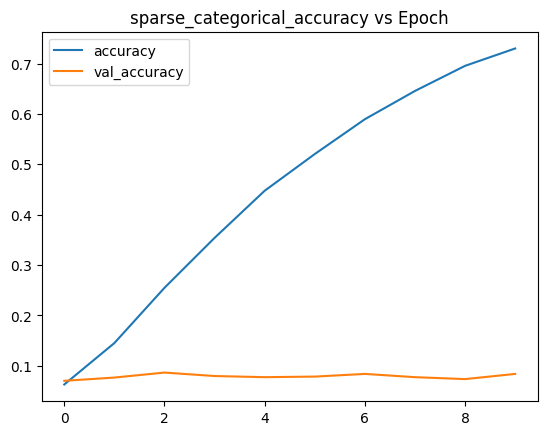

In [ ]:
# Gráfica de accuracy
df2.plot(y=["accuracy", "val_accuracy"], title="sparse_categorical_accuracy vs Epoch")

<Axes: title={'center': 'Loss vs Epoch'}>

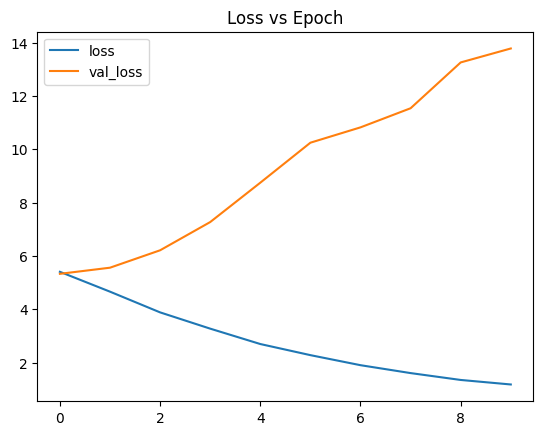

In [ ]:
# Gráfica de pérdida
df2.plot(y=["loss", "val_loss"], title="Loss vs Epoch")

Los resultados obtenidos indican que el modelo tiene un rendimiento significativamente mejor en los datos de entrenamiento en comparación con los datos de validación y prueba.

La pérdida en los datos de entrenamiento (loss) es baja, lo que indica que el modelo se está ajustando bien a esos datos.
La precisión en los datos de entrenamiento (accuracy) es alta (alrededor del 73%).

La pérdida en los datos de validación es alta (alrededor de 13.78), lo que sugiere que el modelo no generaliza bien a nuevos datos. Este es un signo de posible sobreajuste.
La precisión en los datos de validación es baja (alrededor del 8.38%), lo cual es preocupante. Esto indica que el modelo no es capaz de generalizar bien a datos no vistos.

Estos resultados sugieren que el modelo está sobreajustando los datos de entrenamiento, lo que significa que se está adaptando demasiado a esos datos específicos y no generaliza bien a nuevos datos.

## Segundo modelo

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.regularizers import l2

# Modelo CNN con regularización Dropout
model2 = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.20),
    Dense(525, activation='softmax')
])

# Compila el modelo
model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 89, 89, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 87, 87, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 43, 43, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 41, 41, 256)       295168    
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 20, 20, 256)      

In [ ]:
# Entrenamiento del modelo con más capas
history2 = model2.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset
)

# Guardar el historial solo si no existe ya
historial_guardado2 = "2historial_entrenamiento.pkl"
if not os.path.isfile(historial_guardado2):
    with open(historial_guardado2, 'wb') as f:
        pickle.dump(history2.history, f)
# Verificar si el historial existe
if os.path.isfile(historial_guardado2):
    print(f"El historial {historial_guardado2} existe.")
else:
    print(f"El historial {historial_guardado2} no existe.")

Epoch 1/10
 68/424 [===>..........................] - ETA: 3:51:43 - loss: 36.6380 - accuracy: 0.0038

### Evaluación del modelo

In [ ]:
# Evaluar el Segundo modelo
results2 = model2.evaluate(test_dataset, verbose=0)
print(f'Test loss: {results2[0]} / Test accuracy: {results2[1]}')

# Guarda el modelo
model2.save("bird_species_model2.keras")

NameError: ignored

In [ ]:
import pandas as pd
# Convertir resultados a df
dataframe = pd.DataFrame(history2.history)
dataframe

In [ ]:
# Gráfica de accuracy
dataframe.plot(y=["accuracy", "val_accuracy"], title="2º Modelo: sparse_categorical_accuracy vs Epoch")

In [ ]:
# Gráfica de pérdida
dataframe.plot(y=["loss", "val_loss"], title="2º Modelo: Loss vs Epoch")

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Obtén las predicciones para el conjunto de prueba
predictions = model.predict(test_dataset)

# Convierte las predicciones y las etiquetas reales a clases
y_pred_classes = tf.argmax(predictions, axis=1)
y_true_classes = tf.argmax(test_dataset.labels, axis=1)

# Calcula la matriz de confusión
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Visualiza la matriz de confusión con seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


NameError: ignored

In [ ]:
import numpy as np

# Identifica índices de predicciones erróneas
incorrect_indices = np.where(y_pred_classes != y_true_classes)[0]

# Muestra algunas imágenes con predicciones erróneas
plt.figure(figsize=(12, 8))
for i, idx in enumerate(incorrect_indices[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_dataset[idx][0][0].numpy().astype("uint8"))
    plt.title(f"True: {class_names[y_true_classes[idx]]}\nPredicted: {class_names[y_pred_classes[idx]]}")
    plt.axis("off")
plt.show()
